In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import gridspec
from netCDF4 import Dataset
import datetime
import seaborn as sns
import os
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import data
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])
cs2_larm = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_LARM_full.nc')['Radar Freeboard'])
cs2s3_cpom = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_CPOM_full.nc')['Radar Freeboard'])
cs2s3_larm = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_LARM_full.nc')['Radar Freeboard'])

### calculate regional smoothed anomalies

In [3]:
# function to calculate regional means 
def regions_WG(regs):
    WG_mean = []
    WG_c = all_interps.copy()
    for day in np.arange(0,len(all_interps)):
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in np.arange(0,len(all_interps)):
        WG_mean.append(np.nanmean(WG_c[day]))
    return(WG_mean)

# function to calculate running mean, where T = np.int(number of days/2)
def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T]))

    for i in range(np.size(means)-T,np.size(means)):
        r.append(np.nanmean(means[i-T:]))

    return r

In [4]:
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

T = 15 # 31-day running mean
data = [snow,cs2_larm,cs2s3_cpom,cs2s3_larm]
snow_anoms = {} ; cs2_larm_anoms = {} ; cs2s3_cpom_anoms = {} ; cs2s3_larm_anoms = {}
dics = [snow_anoms,cs2_larm_anoms,cs2s3_cpom_anoms,cs2s3_larm_anoms]

for all_interps,dic in zip(data,dics):
    for region, reg in zip(regions, regs):
        dm = regions_WG(reg)
        rm = runningmean(dm,T=15)
        dic[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))

### calculate regional correlation

In [5]:
def stats():
    fb = fb_anoms[region][days]
    snow = snow_anoms[region][days]
    mask = ~np.isnan(fb) & ~np.isnan(snow) 
    try:
        rstats = pearsonr(snow[mask],fb[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        return(p,r)
    except:
        r = np.nan
        p = np.nan

In [6]:
### CS2_LARM ###
fb_anoms = cs2_larm_anoms

# 1 Oct - 30 April
dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2464,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3194,3407), # 2018-2019
        np.arange(3560,3773) # 2019-2020
       ]

ps_table_cs2_larm = np.full((len(dayss),len(regions)),np.nan)
rs_table = np.full((len(dayss),len(regions)),np.nan)

for counter, region in enumerate(regions):
    for count, season in enumerate(dayss):
        days = dayss[count]
        p,r = stats()
        rs_table[count,counter] = r
        ps_table_cs2_larm[count,counter] = p
        
df_cs2_larm = pd.DataFrame(data=rs_table, index=None, columns=None)

###  CS2S3_CPOM ###
days = dayss[9]
fb_anoms = cs2s3_cpom_anoms

ps_table_cs2s3_cpom = np.full((1,len(regions)),np.nan)
rs_table = np.full((1,len(regions)),np.nan)

for counter, region in enumerate(regions):
    p,r = stats()
    rs_table[0,counter] = r
    ps_table_cs2s3_cpom[0,counter] = p
        
df_cs2s3_cpom = pd.DataFrame(data=rs_table, index=None, columns=None)

###  CS2S3_LARM ###
days = dayss[9]
fb_anoms = cs2s3_larm_anoms

ps_table_cs2s3_larm = np.full((1,len(regions)),np.nan)
rs_table = np.full((1,len(regions)),np.nan)

for counter, region in enumerate(regions):
    p,r = stats()
    rs_table[0,counter] = r
    ps_table_cs2s3_larm[0,counter] = p
        
df_cs2s3_larm = pd.DataFrame(data=rs_table, index=None, columns=None)

### plot figure

In [7]:
%%capture output
x = plt.imshow(np.full((3,3),np.nan),vmin=-1,vmax=1,cmap='RdBu')

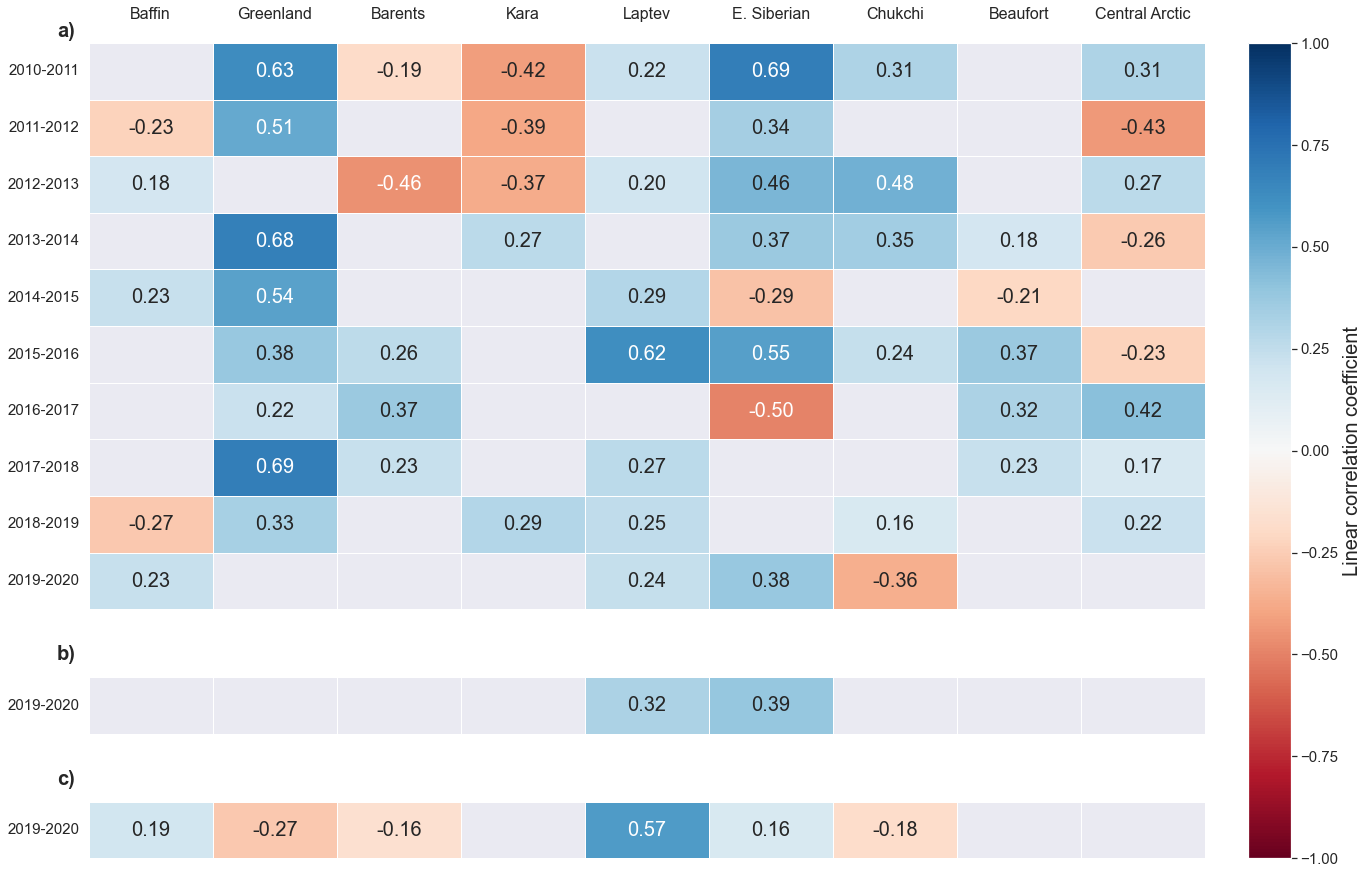

In [8]:
fig = plt.figure(figsize = (20,15))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         width_ratios=[1], wspace=0.5,
                         hspace=0.3, height_ratios=[6,0.6,0.6])

sns.set(rc={'figure.facecolor':'grey'})
# CS2_LARM
ax1 = fig.add_subplot(spec[0])
mask = ps_table_cs2_larm.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019',
          '2019-2020']


ax1 = sns.heatmap(df_cs2_larm, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, cbar=None)
ax1.xaxis.tick_top()
ax1.set_xlabel(' ')    
ax1.set_yticklabels(seasons,rotation = 0,fontsize=15)
ax1.set_xticklabels(regions,fontsize=16,y=1.02)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labeltop=True)
ax1.set_title('a)', x = -0.02,y = 1,fontweight="bold",fontsize=20)

# CS2S3_CPOM
ax2 = fig.add_subplot(spec[1])

mask = ps_table_cs2s3_cpom.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0
seasons = ['2019-2020']

ax2 = sns.heatmap(df_cs2s3_cpom, mask=mask, ax=ax2, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, cbar=None)
ax2.set_xticks([])
ax2.set_yticklabels(seasons,rotation = 0,fontsize=15)
ax2.set_title('b)', x = -0.02,y = 1.2,fontweight="bold",fontsize=20)
        
# CS2S3_LARM
ax3 = fig.add_subplot(spec[2])        
mask = ps_table_cs2s3_larm.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0
seasons = ['2019-2020']
 
ax3 = sns.heatmap(df_cs2s3_larm, mask=mask, ax=ax3, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, cbar=None)
ax3.set_xticks([])
ax3.set_yticklabels(seasons,rotation = 0,fontsize=15)
ax3.set_title('c)', x = -0.02,y = 1.2,fontweight="bold",fontsize=20)

cbar_ax = fig.add_axes([0.93, 0.125, 0.03, 0.755])
cb = fig.colorbar(x, cax=cbar_ax)
cb.set_label("Linear correlation coefficient",fontsize = 20)
cb.ax.tick_params(labelsize=15)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/supp_regional_stats.png',bbox_inches = "tight")